In [1]:
# Import packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from functools import partial
import copy
import matplotlib.pyplot as plt

Define functions and classes:

In [2]:
# Define the gold standard neural network class inheriting from nn.Module
class gs_neural_net(nn.Module):
    def __init__(self, hidden_layers_vector):
        super(gs_neural_net, self).__init__()
        self.input_size = 16
        self.output_size = 8
        self.num_actions = 8
        self.hidden_layers_vector = hidden_layers_vector

        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(self.input_size, self.hidden_layers_vector[0]))
        for i in range(1, len(self.hidden_layers_vector)):
            self.hidden_layers.append(nn.Linear(self.hidden_layers_vector[i - 1] + self.num_actions, self.hidden_layers_vector[i]))
        self.output_layer = nn.Linear(self.hidden_layers_vector[-1] + self.num_actions, self.output_size)

        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.zeros_(self.hidden_layers[0].bias)
        nn.init.kaiming_normal_(self.hidden_layers[0].weight, mode='fan_in', nonlinearity='relu')

        for i in range(1, len(self.hidden_layers)):
            nn.init.kaiming_normal_(self.hidden_layers[i].weight, mode='fan_in', nonlinearity='relu')
            nn.init.zeros_(self.hidden_layers[i].bias)

        nn.init.zeros_(self.output_layer.bias)
        nn.init.kaiming_normal_(self.output_layer.weight, mode='fan_in', nonlinearity='linear')

    def forward(self, x):
        actions = x[:, 8:]
        h = F.relu(self.hidden_layers[0](x))
        for layer in self.hidden_layers[1:]:
            # Add a skip-layer connection for the actions so that they meaningfully affect the outcome
            h = F.relu(layer(torch.cat([h, actions], dim=1)))
        # Increase the final skip-layer connection to further increase the impact of actions
        output = self.output_layer(torch.cat([h, actions * 2 * h.size(1) ** 0.5], dim=1))
        return F.softmax(output, dim=1)

In [3]:
# Define the data generation process for the eight environmental variables
def generate_environment(num_samples=(2 ** 16)):
    #Multiplying by sqrt(12) gives U(0,1) the same variance as N(0,1), but keeps it over a bounded range
    environments = (12 ** 0.5) * torch.rand(num_samples, 8)
    return environments

In [4]:
# Define a function to add each of eight possible actions to each environment, creating inputs of length sixteen
def expand_tensor(input_tensor):
    if input_tensor.dim() == 1:
        input_tensor = input_tensor.unsqueeze(0)
    expanded_tensor = torch.zeros((input_tensor.shape[0] * 8, input_tensor.shape[1] + 8))
    for i in range(input_tensor.shape[0]):
        vector = input_tensor[i]
        for j in range(8):
            appended_vector = torch.zeros(8)
            appended_vector[j] = 1
            expanded_tensor[8 * i + j, :] = torch.cat([vector, appended_vector])
    return expanded_tensor

In [5]:
# Define a variant on DataLoader that will sample data in blocks of eight
# This ensures all eight actions for the same environment appear adjacent in the same block
class BlockLoader:
    def __init__(self, inputs, model=None, block_size=8, batch_size=64):
        self.inputs = inputs
        self.targets = None
        self.block_size = block_size
        self.batch_size = batch_size
        self.num_samples = self.inputs.shape[0]
        self.num_blocks = self.num_samples // self.block_size

        if model is not None:
          self.update_targets(model)

    def update_targets(self, model):
        with torch.no_grad():
            self.targets = model(self.inputs)

    def __iter__(self):
        block_indices = torch.randperm(self.num_blocks)

        for i in range(0, self.num_blocks, self.batch_size):
            batch_block_indices = block_indices[i:i + self.batch_size]
            batch_inputs = []

            for id in batch_block_indices:
                start_id = id * self.block_size
                end_id = start_id + self.block_size
                batch_inputs.append(self.inputs[start_id:end_id])

            if self.targets is not None:
                batch_targets = []
                for id in batch_block_indices:
                    start_id = id * self.block_size
                    end_id = start_id + self.block_size
                    batch_targets.append(self.targets[start_id:end_id])
                yield torch.cat(batch_inputs, dim=0), torch.cat(batch_targets, dim=0)
            else:
                yield torch.cat(batch_inputs, dim=0)

    def __len__(self):
        return self.num_samples // (self.batch_size * self.block_size)

In [6]:
# Define the neural network to be trained
class neural_network(nn.Module):
    def __init__(self, num_hidden_layers=4, hidden_size=64, hidden_dropout_rate=0.5, input_dropout_rate=0.25):
        super(neural_network, self).__init__()
        self.input_size = 16
        self.output_size = 8
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers

        self.hidden_dropout_rate = hidden_dropout_rate
        self.input_dropout_rate = input_dropout_rate

        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(self.input_size, self.hidden_size))
        for _ in range(1, self.num_hidden_layers):
            self.hidden_layers.append(nn.Linear(self.hidden_size, self.hidden_size))
        self.output_layer = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        batch_size = x.size(0)

        if self.training and self.input_dropout_rate > 0:
            # Apply input dropout to the first 8 values, representing the environment, but not the actions which are all being conditionally predicted
            # The same dropout mask is applied to all eight actions with the same environment
            input_mask = F.dropout(torch.ones(batch_size // 8, 8), p=self.input_dropout_rate, training=True)
            input_mask = input_mask.repeat_interleave(8, dim=0)
            input_mask = torch.cat([input_mask, torch.ones(batch_size, 8)], dim=1)
            x = torch.mul(x, input_mask)

        for layer in self.hidden_layers:
            x = F.relu(layer(x))

            if self.training and self.hidden_dropout_rate > 0:
                mask = F.dropout(torch.ones(batch_size // 8, layer.out_features), p=self.hidden_dropout_rate, training=True)
                mask = mask.repeat_interleave(8, dim=0)
                x = torch.mul(x, mask)

        x = self.output_layer(x)
        return F.softmax(x, dim=1)

In [7]:
# Training function
def train_model(model, optimizer, criterion, data_loader, epochs, report_interval=None, record_loss=False):
    if report_interval is not None:
      total_loss = 0
      total_ideal_loss = 0.0
      batch_count = 0

    if record_loss:
      batch_losses = []
      batch_ideal_losses = []

    model.train()
    for epoch in range(epochs):
        for inputs, targets in data_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            ideal_loss = criterion(targets, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            # Record losses
            if record_loss:
              batch_losses.append(loss.item())
              batch_ideal_losses.append(ideal_loss.item())


            # Report average loss every X batches
            if report_interval is not None:
              total_loss += loss.item()
              total_ideal_loss += ideal_loss.item()
              batch_count += 1
              if batch_count % report_interval == 0:
                  print(f'Epoch {epoch + 1}, Batch {batch_count}, Average Loss: {total_loss/ report_interval}, Ideal Loss: {total_ideal_loss/ report_interval}')
                  total_loss = 0.0
                  total_ideal_loss = 0.0

    if record_loss:
      # Convert lists to tensors
      batch_losses_tensor = torch.tensor(batch_losses)
      batch_ideal_losses_tensor = torch.tensor(batch_ideal_losses)

      # Output the records of losses
      return batch_losses_tensor, batch_ideal_losses_tensor

In [8]:
# Loss function (Kullback-Leibler Divergence, weighted by probability of choosing that action, ignore term that depends only on y_true)
def criterion_pretraining(y_pred, y_true):
    log_probs = torch.log(y_pred + 1e-10)
    loss = -torch.sum(y_true * log_probs, dim=1)
    return torch.mean(loss)

In [9]:
# Training function
def train_model_performative(model, utilities, optimizer, criterion, data_loader, epochs, report_interval=None, record_loss = False):
    if report_interval is not None:
      total_loss = 0
      total_np_loss = 0
      total_prob_fav = 0
      total_utility = 0
      batch_count = 0

    if record_loss:
      batch_losses = []
      batch_np_losses = []
      batch_prob_favs = []
      batch_utilities = []

    model.train()
    for epoch in range(epochs):
        for inputs, targets in data_loader:
            optimizer.zero_grad()

            #Two forward passes for comparison to zero-sum model
            outputs1 = model(inputs)
            outputs2 = model(inputs)

            loss1, np_loss1, prob_fav1, utility1 = criterion(outputs1, targets, utilities)
            loss2, np_loss2, prob_fav2, utility2 = criterion(outputs2, targets, utilities)
            loss = (loss1 + loss2)/2
            np_loss = (np_loss1 + np_loss2)/2
            prob_fav = (prob_fav1 + prob_fav2)/2
            utility = (utility1 + utility2)/2

            loss.backward()
            optimizer.step()

            if record_loss:
              batch_losses.append(loss.item())
              batch_np_losses.append(np_loss.item())
              batch_prob_favs.append(prob_fav.item())
              batch_utilities.append(utility.item())

            if report_interval is not None:
              total_loss += loss.item()
              total_np_loss += np_loss.item()
              total_prob_fav += prob_fav.item()
              total_utility += utility.item()
              batch_count += 1
              if batch_count % report_interval == 0:
                print(f'Epoch {epoch + 1}, Batch {batch_count}, Average Loss: {total_loss/ report_interval:.5f}, Average NP Loss: {total_np_loss/ report_interval:.5f}, Average Prob Fav: {total_prob_fav/ report_interval:.5f}, Average Utility: {total_utility/ report_interval:.5f} ')
                total_loss = 0.0
                total_np_loss = 0.0
                total_prob_fav = 0.0
                total_utility = 0.0

    if record_loss:
      batch_losses_tensor = torch.tensor(batch_losses)
      batch_np_losses_tensor = torch.tensor(batch_np_losses)
      batch_prob_favs_tensor = torch.tensor(batch_prob_favs)
      batch_utilities_tensor = torch.tensor(batch_utilities)

      return batch_losses_tensor, batch_np_losses_tensor, batch_prob_favs_tensor, batch_utilities_tensor

In [10]:
# Loss function (Kullback-Leibler Divergence, weighted by probability of choosing that action, ignoring term that depends only on y_true)
def criterion_performative(y_pred, y_true, utilities):
    # The principal's probability of choosing each action
    action_values = y_pred @ utilities
    reshaped_av = action_values.reshape(action_values.size(0)//8, 8)
    action_probs = F.softmax(reshaped_av, dim=1)
    action_probs = action_probs.reshape(action_values.size(0))
    # The agent's score conditional on each action
    log_probs = torch.log(y_pred + 1e-10)
    unweighted_losses = -torch.sum(y_true * log_probs, dim=1)
    # Weighting
    weighted_losses = unweighted_losses * action_probs

    # The principal's preferred action under the true distributions
    true_action_values = y_true @ utilities
    reshaped_tav = true_action_values.reshape(true_action_values.size(0)//8, 8)
    max_indices = torch.argmax(reshaped_tav, dim=1)
    favorites = torch.zeros_like(reshaped_tav)
    favorites[torch.arange(reshaped_tav.shape[0]), max_indices] = 1
    favorites = favorites.reshape(true_action_values.size(0))
    prob_fav = favorites * action_probs
    utility = true_action_values * action_probs

    return torch.mean(weighted_losses * 8), torch.mean(unweighted_losses), torch.mean(prob_fav * 8), torch.mean(utility * 8)


In [11]:
# Training function
def train_model_zero_sum(model, utilities, optimizer, criterion, data_loader, epochs, report_interval=None, record_loss = False):
    if report_interval is not None:
      total_loss = 0
      total_w_loss = 0
      total_np_loss = 0
      total_prob_fav = 0
      total_utility = 0
      batch_count = 0

    if record_loss:
      batch_w_losses = []
      batch_np_losses = []
      batch_prob_favs = []
      batch_utilities = []

    model.train()
    for epoch in range(epochs):
        for inputs, targets in data_loader:
            optimizer.zero_grad()

            outputs1 = model(inputs)
            outputs2 = model(inputs)

            loss1, w_loss1, np_loss1, prob_fav1, utility1 = criterion(outputs1, outputs2.detach(), targets, utilities)
            loss2, w_loss2, np_loss2, prob_fav2, utility2 = criterion(outputs2, outputs1.detach(), targets, utilities)
            loss = (loss1 + loss2)/2
            w_loss = (w_loss1 + w_loss2)/2
            np_loss = (np_loss1 + np_loss2)/2
            prob_fav = (prob_fav1 + prob_fav2)/2
            utility = (utility1 + utility2)/2

            loss.backward()
            optimizer.step()

            if record_loss:
              batch_w_losses.append(w_loss.item())
              batch_np_losses.append(np_loss.item())
              batch_prob_favs.append(prob_fav.item())
              batch_utilities.append(utility.item())

            if report_interval is not None:
              total_loss += loss.item()
              total_w_loss += w_loss.item()
              total_np_loss += np_loss.item()
              total_prob_fav += prob_fav.item()
              total_utility += utility.item()
              batch_count += 1
              if batch_count % report_interval == 0:
                print(f'Epoch {epoch + 1}, Batch {batch_count}, Average Loss: {total_loss/ report_interval:.5f}, Average W Loss: {total_w_loss/ report_interval:.5f}, Average NP Loss: {total_np_loss/ report_interval:.5f}, Average Prob Fav: {total_prob_fav/ report_interval:.5f}, Average Utility: {total_utility/ report_interval:.5f} ')
                total_loss = 0.0
                total_w_loss = 0.0
                total_np_loss = 0.0
                total_prob_fav = 0.0
                total_utility = 0.0

    if record_loss:
      batch_w_losses_tensor = torch.tensor(batch_w_losses)
      batch_np_losses_tensor = torch.tensor(batch_np_losses)
      batch_prob_favs_tensor = torch.tensor(batch_prob_favs)
      batch_utilities_tensor = torch.tensor(batch_utilities)

      return batch_w_losses_tensor, batch_np_losses_tensor, batch_prob_favs_tensor, batch_utilities_tensor

In [12]:
# Training function
def train_model_zero_sum_exact(model, utilities, optimizer, criterion, data_loader, epochs, report_interval=None, record_loss = False):
    if report_interval is not None:
      total_loss = 0
      total_w_loss = 0
      total_np_loss = 0
      total_prob_fav = 0
      total_utility = 0
      batch_count = 0

    if record_loss:
      batch_w_losses = []
      batch_np_losses = []
      batch_prob_favs = []
      batch_utilities = []

    model.train()
    for epoch in range(epochs):
        for inputs, targets in data_loader:
            optimizer.zero_grad()

            outputs1 = model(inputs)
            outputs2 = model(inputs)

            loss1, w_loss1, np_loss1, prob_fav1, utility1 = criterion(outputs1, outputs1.detach(), targets, utilities)
            loss2, w_loss2, np_loss2, prob_fav2, utility2 = criterion(outputs2, outputs2.detach(), targets, utilities)
            loss = (loss1 + loss2)/2
            w_loss = (w_loss1 + w_loss2)/2
            np_loss = (np_loss1 + np_loss2)/2
            prob_fav = (prob_fav1 + prob_fav2)/2
            utility = (utility1 + utility2)/2

            loss.backward()
            optimizer.step()

            if record_loss:
              batch_w_losses.append(w_loss.item())
              batch_np_losses.append(np_loss.item())
              batch_prob_favs.append(prob_fav.item())
              batch_utilities.append(utility.item())

            if report_interval is not None:
              total_loss += loss.item()
              total_w_loss += w_loss.item()
              total_np_loss += np_loss.item()
              total_prob_fav += prob_fav.item()
              total_utility += utility.item()
              batch_count += 1
              if batch_count % report_interval == 0:
                print(f'Epoch {epoch + 1}, Batch {batch_count}, Average Loss: {total_loss/ report_interval:.5f}, Average W Loss: {total_w_loss/ report_interval:.5f}, Average NP Loss: {total_np_loss/ report_interval:.5f}, Average Prob Fav: {total_prob_fav/ report_interval:.5f}, Average Utility: {total_utility/ report_interval:.5f} ')
                total_loss = 0.0
                total_w_loss = 0.0
                total_np_loss = 0.0
                total_prob_fav = 0.0
                total_utility = 0.0

    if record_loss:
      batch_w_losses_tensor = torch.tensor(batch_w_losses)
      batch_np_losses_tensor = torch.tensor(batch_np_losses)
      batch_prob_favs_tensor = torch.tensor(batch_prob_favs)
      batch_utilities_tensor = torch.tensor(batch_utilities)

      return batch_w_losses_tensor, batch_np_losses_tensor, batch_prob_favs_tensor, batch_utilities_tensor

In [13]:
# Loss function (Kullback-Leibler Divergence, weighted by probability of choosing that action, ignore term that depends only on y_true)
def criterion_zero_sum(y_pred1, y_pred2, y_true, utilities):
    # The principal's probability of choosing each action
    action_values_1 = y_pred1 @ utilities
    action_values_2 = y_pred2 @ utilities
    action_values_optimistic = torch.max(action_values_1, action_values_2)
    reshaped_av = action_values_optimistic.reshape(action_values_optimistic.size(0)//8, 8)
    action_probs = F.softmax(reshaped_av, dim=1)
    action_probs = action_probs.reshape(action_values_optimistic.size(0))
    # The agent's score conditional on each action
    log_probs1 = torch.log(y_pred1 + 1e-10)
    log_probs2 = torch.log(y_pred2 + 1e-10)
    unweighted_losses1 = -torch.sum(y_true * log_probs1, dim=1)
    unweighted_losses2 = -torch.sum(y_true * log_probs2, dim=1)
    # Weighting
    weighted_losses1 = unweighted_losses1 * action_probs
    weighted_losses2 = unweighted_losses2 * action_probs
    zero_sum_losses = weighted_losses1 - weighted_losses2

    # The principal's preferred action under the true distributions
    true_action_values = y_true @ utilities
    reshaped_tav = true_action_values.reshape(true_action_values.size(0)//8, 8)
    max_indices = torch.argmax(reshaped_tav, dim=1)
    favorites = torch.zeros_like(reshaped_tav)
    favorites[torch.arange(reshaped_tav.shape[0]), max_indices] = 1
    favorites = favorites.reshape(true_action_values.size(0))
    prob_fav = favorites * action_probs
    utility = true_action_values * action_probs

    return torch.mean(zero_sum_losses * 8), torch.mean(weighted_losses1 * 8), torch.mean(unweighted_losses1), torch.mean(prob_fav * 8), torch.mean(utility * 8)


Evaluation:

In [14]:
# Set random seed
torch.manual_seed(0)

In [15]:
# Generate pretraining and finetuning loaders, test inputs
loader_pretraining = BlockLoader(expand_tensor(generate_environment(2 ** 16)))
loader_finetuning = BlockLoader(expand_tensor(generate_environment(2 ** 14)))
inputs_test = expand_tensor(generate_environment(2 ** 12))

In [16]:
# Set up to run the training process repeatedly, with random utility functions
n_models = 4
n_utilities = 16
pretraining_epochs = 1
finetuning_epochs = 1
n_batches = 256 * finetuning_epochs

loss_record_p = torch.zeros((n_batches, n_utilities, n_models))
np_loss_record_p = torch.zeros((n_batches, n_utilities, n_models))
prob_fav_record_p = torch.zeros((n_batches, n_utilities, n_models))
utility_record_p = torch.zeros((n_batches, n_utilities, n_models))
loss_final_p = torch.zeros(n_utilities, n_models)
np_loss_final_p = torch.zeros(n_utilities, n_models)
prob_fav_final_p = torch.zeros(n_utilities, n_models)
utility_final_p = torch.zeros(n_utilities, n_models)

loss_record_zs = torch.zeros((n_batches, n_utilities, n_models))
np_loss_record_zs = torch.zeros((n_batches, n_utilities, n_models))
prob_fav_record_zs = torch.zeros((n_batches, n_utilities, n_models))
utility_record_zs = torch.zeros((n_batches, n_utilities, n_models))
loss_final_zs = torch.zeros(n_utilities, n_models)
np_loss_final_zs = torch.zeros(n_utilities, n_models)
prob_fav_final_zs = torch.zeros(n_utilities, n_models)
utility_final_zs = torch.zeros(n_utilities, n_models)

loss_record_zs_exact = torch.zeros((n_batches, n_utilities, n_models))
np_loss_record_zs_exact = torch.zeros((n_batches, n_utilities, n_models))
prob_fav_record_zs_exact = torch.zeros((n_batches, n_utilities, n_models))
utility_record_zs_exact = torch.zeros((n_batches, n_utilities, n_models))
loss_final_zs_exact = torch.zeros(n_utilities, n_models)
np_loss_final_zs_exact = torch.zeros(n_utilities, n_models)
prob_fav_final_zs_exact = torch.zeros(n_utilities, n_models)
utility_final_zs_exact = torch.zeros(n_utilities, n_models)

In [17]:
# Run the training process repeatedly for models and utility functions
utilities = torch.randn(n_utilities, 8)
for i in range(n_models):
    # Create the ground truth model and train a base model to predict it
    model_gs = gs_neural_net([1024])
    with torch.no_grad():
      loader_pretraining.update_targets(model_gs)
      loader_finetuning.update_targets(model_gs)
      gs_pred = model_gs(inputs_test)
    model_pretraining = neural_network(num_hidden_layers=4, hidden_size=64)
    optimizer_pretraining = optim.Adam(model_pretraining.parameters())
    train_model(model_pretraining, optimizer_pretraining, criterion_pretraining, loader_pretraining, epochs=pretraining_epochs,
                report_interval = None, record_loss = False)
    optimizer_pretraining.zero_grad()
    for j in range(n_utilities):
      utility = utilities[j:j+1,:].squeeze()
      utility = 16 * (utility - torch.min(utility)) / (torch.max(utility) - torch.min(utility))
      # Train a model from the base model to do performative prediction, recording the training process and final output
      with torch.no_grad():
        model_performative = copy.deepcopy(model_pretraining)
      optimizer_performative = optim.Adam(model_performative.parameters())
      loss_record_p[:,j,i], np_loss_record_p[:,j,i], prob_fav_record_p[:,j,i], utility_record_p[:,j,i] = train_model_performative(model_performative,
                         utility, optimizer_performative, criterion_performative, loader_finetuning, finetuning_epochs, record_loss = True)
      with torch.no_grad():
        performative_pred = model_performative(inputs_test)
        loss_final_p[j,i], np_loss_final_p[j,i], prob_fav_final_p[j,i], utility_final_p[j,i] = criterion_performative(performative_pred, gs_pred, utility)
      optimizer_performative.zero_grad()
      del model_performative, optimizer_performative
      # Repeat the process for the zero-sum model
      with torch.no_grad():
        model_zero_sum = copy.deepcopy(model_pretraining)
      optimizer_zero_sum = optim.Adam(model_zero_sum.parameters())
      loss_record_zs[:,j,i], np_loss_record_zs[:,j,i], prob_fav_record_zs[:,j,i], utility_record_zs[:,j,i] = train_model_zero_sum(model_zero_sum,
                         utility, optimizer_zero_sum, criterion_zero_sum, loader_finetuning, finetuning_epochs, record_loss = True)
      with torch.no_grad():
        zero_sum_pred = model_zero_sum(inputs_test)
        loss_final_zs[j,i], np_loss_final_zs[j,i], prob_fav_final_zs[j,i], utility_final_zs[j,i] = criterion_performative(zero_sum_pred, gs_pred, utility)
      optimizer_zero_sum.zero_grad()
      del model_zero_sum, optimizer_zero_sum
      # Repeat the process for the exact zero-sum model
      with torch.no_grad():
        model_zero_sum_exact = copy.deepcopy(model_pretraining)
      optimizer_zero_sum_exact = optim.Adam(model_zero_sum_exact.parameters())
      loss_record_zs_exact[:,j,i], np_loss_record_zs_exact[:,j,i], prob_fav_record_zs_exact[:,j,i], utility_record_zs_exact[:,j,i] = train_model_zero_sum_exact(model_zero_sum_exact,
                         utility, optimizer_zero_sum_exact, criterion_zero_sum, loader_finetuning, finetuning_epochs, record_loss = True)
      with torch.no_grad():
        zero_sum_pred_exact = model_zero_sum_exact(inputs_test)
        loss_final_zs_exact[j,i], np_loss_final_zs_exact[j,i], prob_fav_final_zs_exact[j,i], utility_final_zs_exact[j,i] = criterion_performative(zero_sum_pred_exact, gs_pred, utility)
      optimizer_zero_sum_exact.zero_grad()
      del model_zero_sum_exact, optimizer_zero_sum_exact

      print('Model: ', i+1, ', Training Run:', j+1, ' Complete')
    del model_pretraining, model_gs

Model:  1 , Training Run: 1  Complete
Model:  1 , Training Run: 2  Complete
Model:  1 , Training Run: 3  Complete
Model:  1 , Training Run: 4  Complete
Model:  1 , Training Run: 5  Complete
Model:  1 , Training Run: 6  Complete
Model:  1 , Training Run: 7  Complete
Model:  1 , Training Run: 8  Complete
Model:  1 , Training Run: 9  Complete
Model:  1 , Training Run: 10  Complete
Model:  1 , Training Run: 11  Complete
Model:  1 , Training Run: 12  Complete
Model:  1 , Training Run: 13  Complete
Model:  1 , Training Run: 14  Complete
Model:  1 , Training Run: 15  Complete
Model:  1 , Training Run: 16  Complete
Model:  2 , Training Run: 1  Complete
Model:  2 , Training Run: 2  Complete
Model:  2 , Training Run: 3  Complete
Model:  2 , Training Run: 4  Complete
Model:  2 , Training Run: 5  Complete
Model:  2 , Training Run: 6  Complete
Model:  2 , Training Run: 7  Complete
Model:  2 , Training Run: 8  Complete
Model:  2 , Training Run: 9  Complete
Model:  2 , Training Run: 10  Complete
Mode

In [18]:
# Print final comparison stats
print(f'Performative: Loss - {loss_final_p.mean():.4f}, Non-Performative Loss - {np_loss_final_p.mean():.4f}, Probability of Favorite - {prob_fav_final_p.mean():.4f}, Utility - {utility_final_p.mean():.4f}')
print(f'Zero-Sum: Loss - {loss_final_zs.mean():.4f}, Non-Performative Loss - {np_loss_final_zs.mean():.4f}, Probability of Favorite - {prob_fav_final_zs.mean():.4f}, Utility - {utility_final_zs.mean():.4f}')
print(f'Exact Zero-Sum: Loss - {loss_final_zs_exact.mean():.4f}, Non-Performative Loss - {np_loss_final_zs_exact.mean():.4f}, Probability of Favorite - {prob_fav_final_zs_exact.mean():.4f}, Utility - {utility_final_zs_exact.mean():.4f}')

Performative: Loss - 0.5685, Non-Performative Loss - 5.0510, Probability of Favorite - 0.4549, Utility - 11.1264
Zero-Sum: Loss - 0.9700, Non-Performative Loss - 1.2447, Probability of Favorite - 0.6940, Utility - 12.4390
Exact Zero-Sum: Loss - 0.9581, Non-Performative Loss - 1.2771, Probability of Favorite - 0.7027, Utility - 12.4586


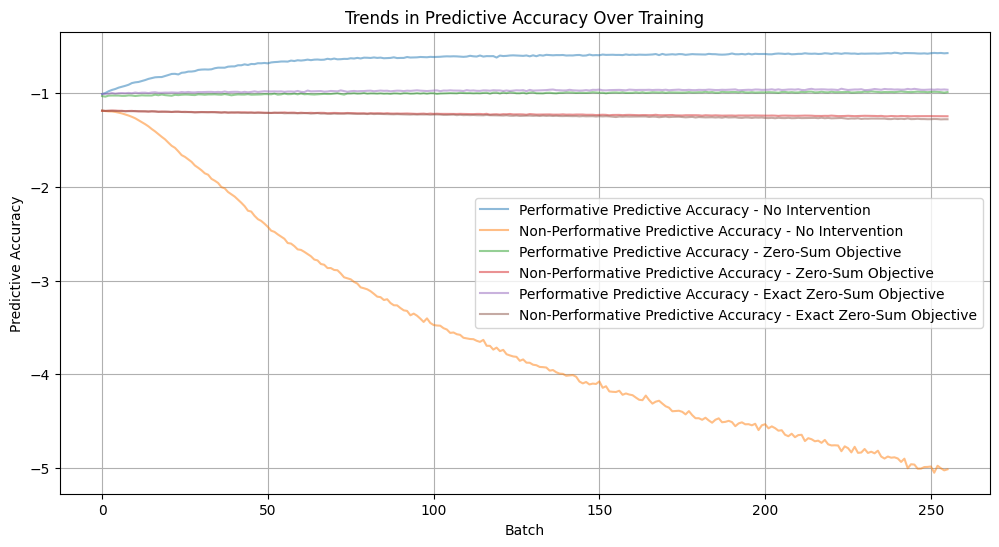

In [19]:
# Plot the predictive accuracy across batches
batch_num = torch.arange(n_batches)

plt.figure(figsize=(12, 6))
plt.plot(batch_num, -1 * torch.mean(loss_record_p, dim=(1,2)), label='Performative Predictive Accuracy - No Intervention', alpha=0.5)
plt.plot(batch_num, -1 * torch.mean(np_loss_record_p, dim=(1,2)), label='Non-Performative Predictive Accuracy - No Intervention', alpha=0.5)
plt.plot(batch_num, -1 * torch.mean(loss_record_zs, dim=(1,2)), label='Performative Predictive Accuracy - Zero-Sum Objective', alpha=0.5)
plt.plot(batch_num, -1 * torch.mean(np_loss_record_zs, dim=(1,2)), label='Non-Performative Predictive Accuracy - Zero-Sum Objective', alpha=0.5)
plt.plot(batch_num, -1 * torch.mean(loss_record_zs_exact, dim=(1,2)), label='Performative Predictive Accuracy - Exact Zero-Sum Objective', alpha=0.5)
plt.plot(batch_num, -1 * torch.mean(np_loss_record_zs_exact, dim=(1,2)), label='Non-Performative Predictive Accuracy - Exact Zero-Sum Objective', alpha=0.5)

plt.xlabel('Batch')
plt.ylabel('Predictive Accuracy')
plt.title('Trends in Predictive Accuracy Over Training')
plt.legend()
plt.grid(True)
plt.show()

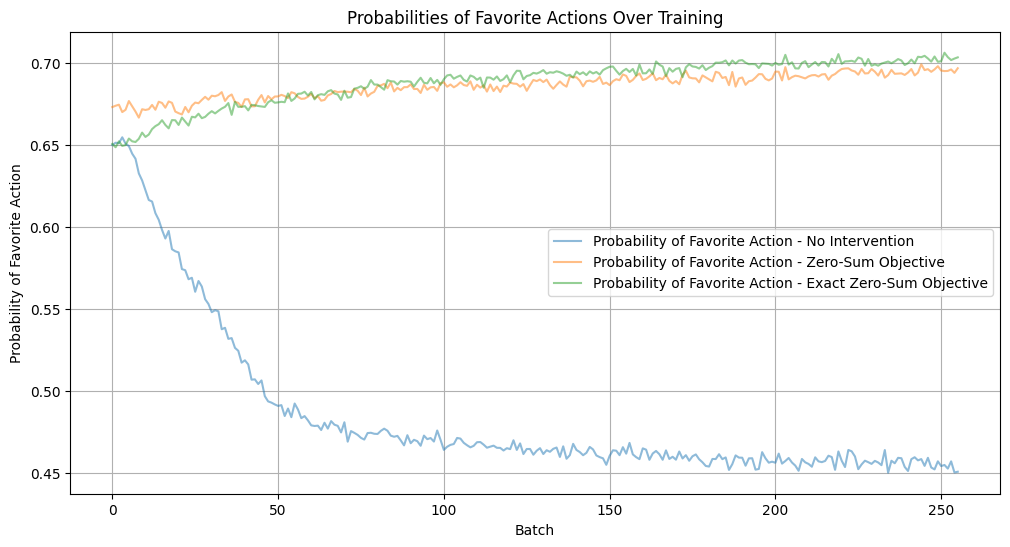

In [20]:
# Plot the probability of the favorite action across batches
batch_num = torch.arange(n_batches)

plt.figure(figsize=(12, 6))
plt.plot(batch_num, torch.mean(prob_fav_record_p, dim=(1,2)), label='Probability of Favorite Action - No Intervention', alpha=0.5)
plt.plot(batch_num, torch.mean(prob_fav_record_zs, dim=(1,2)), label='Probability of Favorite Action - Zero-Sum Objective', alpha=0.5)
plt.plot(batch_num, torch.mean(prob_fav_record_zs_exact, dim=(1,2)), label='Probability of Favorite Action - Exact Zero-Sum Objective', alpha=0.5)

plt.xlabel('Batch')
plt.ylabel('Probability of Favorite Action')
plt.title('Probabilities of Favorite Actions Over Training')
plt.legend()
plt.grid(True)
plt.show()

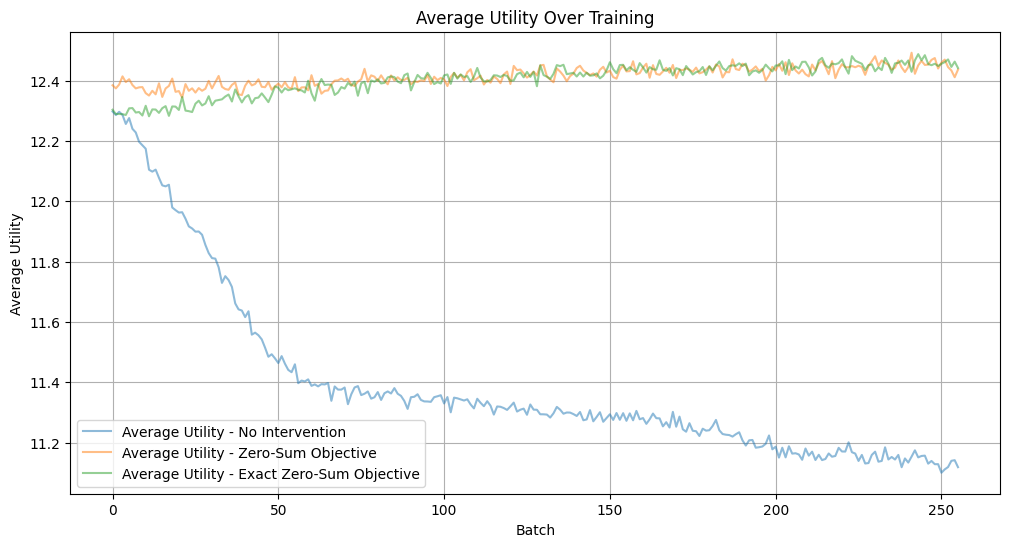

In [21]:
# Plot the average utility across batches
batch_num = torch.arange(n_batches)

plt.figure(figsize=(12, 6))
plt.plot(batch_num, torch.mean(utility_record_p, dim=(1,2)), label='Average Utility - No Intervention', alpha=0.5)
plt.plot(batch_num, torch.mean(utility_record_zs, dim=(1,2)), label='Average Utility - Zero-Sum Objective', alpha=0.5)
plt.plot(batch_num, torch.mean(utility_record_zs_exact, dim=(1,2)), label='Average Utility - Exact Zero-Sum Objective', alpha=0.5)

plt.xlabel('Batch')
plt.ylabel('Average Utility')
plt.title('Average Utility Over Training')
plt.legend()
plt.grid(True)
plt.show()

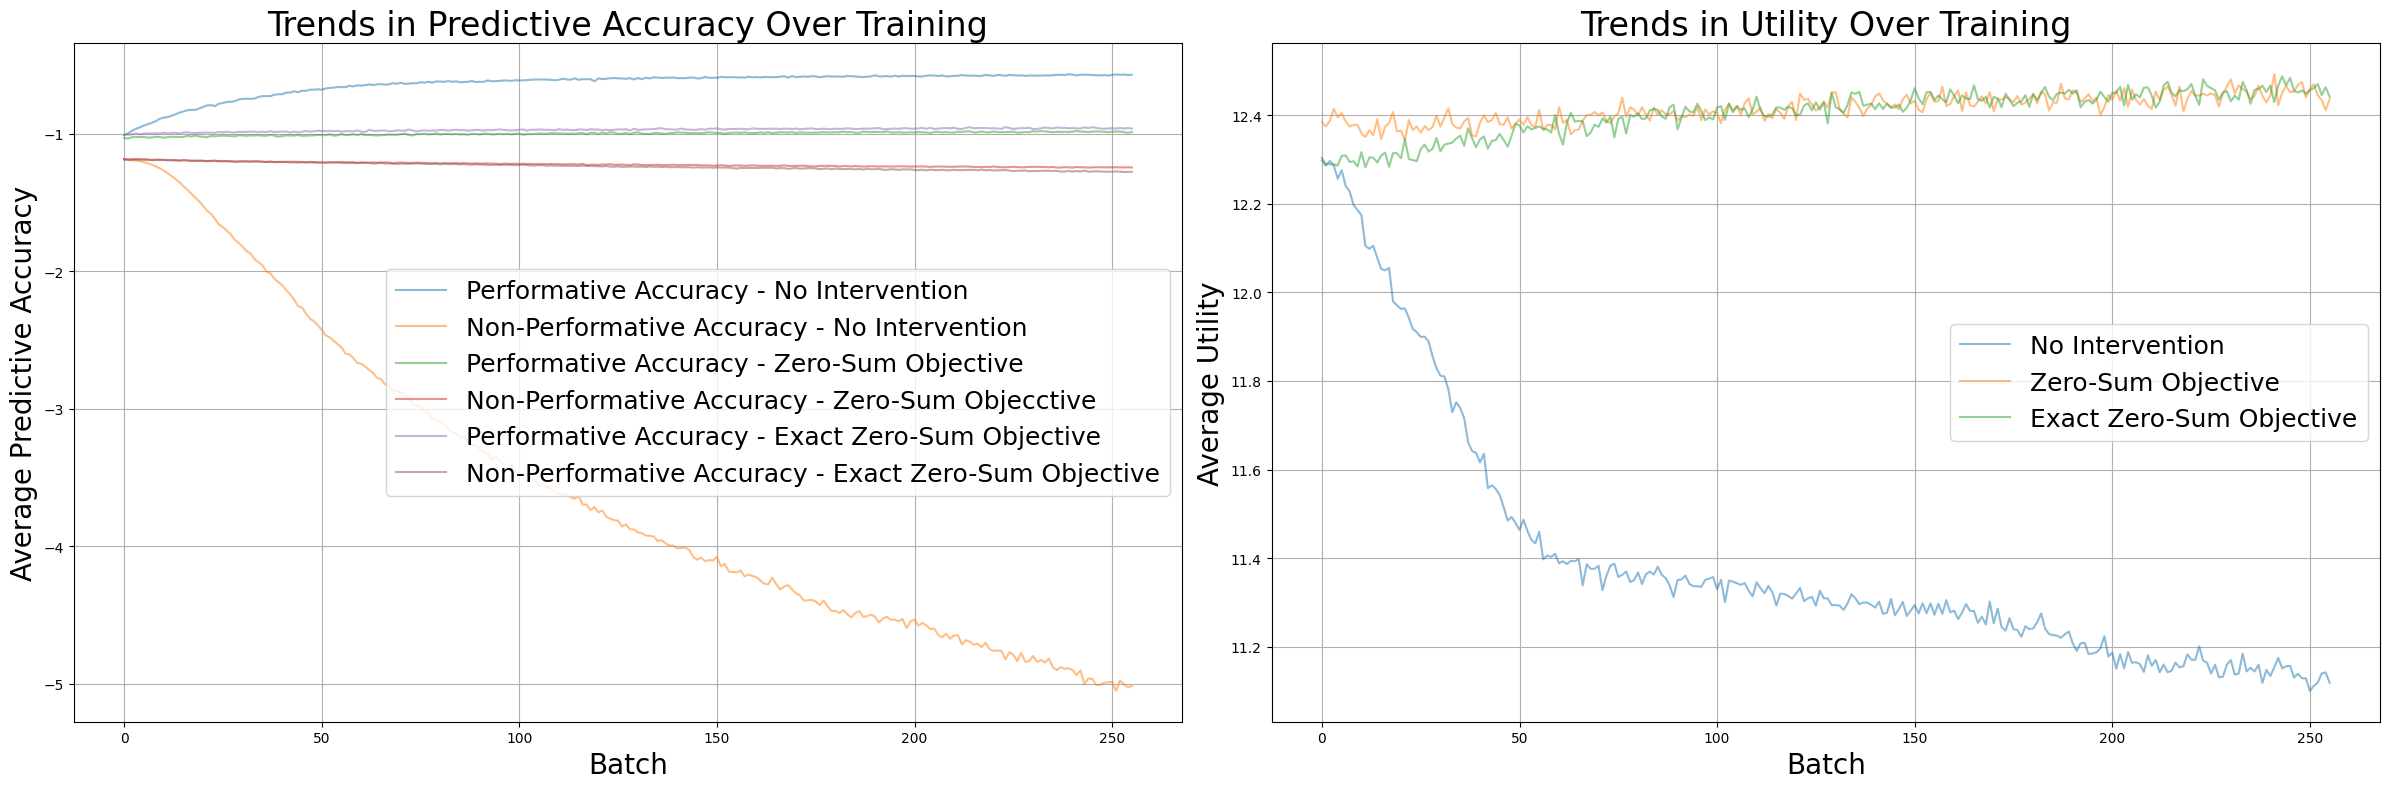

In [22]:
batch_num = torch.arange(n_batches)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

# Plot the losses across batches
ax1.plot(batch_num, -1 * torch.mean(loss_record_p, dim=(1,2)), label='Performative Accuracy - No Intervention', alpha=0.5)
ax1.plot(batch_num, -1 * torch.mean(np_loss_record_p, dim=(1,2)), label='Non-Performative Accuracy - No Intervention', alpha=0.5)
ax1.plot(batch_num, -1 * torch.mean(loss_record_zs, dim=(1,2)), label='Performative Accuracy - Zero-Sum Objective', alpha=0.5)
ax1.plot(batch_num, -1 * torch.mean(np_loss_record_zs, dim=(1,2)), label='Non-Performative Accuracy - Zero-Sum Objecctive', alpha=0.5)
ax1.plot(batch_num, -1 * torch.mean(loss_record_zs_exact, dim=(1,2)), label='Performative Accuracy - Exact Zero-Sum Objective', alpha=0.5)
ax1.plot(batch_num, -1 * torch.mean(np_loss_record_zs_exact, dim=(1,2)), label='Non-Performative Accuracy - Exact Zero-Sum Objective', alpha=0.5)
ax1.set_xlabel('Batch', fontsize=20)
ax1.set_ylabel('Average Predictive Accuracy', fontsize=20)
ax1.set_title('Trends in Predictive Accuracy Over Training', fontsize=24)
ax1.legend(fontsize=18)
ax1.grid(True)

# Plot the average utility across batches
ax2.plot(batch_num, torch.mean(utility_record_p, dim=(1,2)), label='No Intervention', alpha=0.5)
ax2.plot(batch_num, torch.mean(utility_record_zs, dim=(1,2)), label='Zero-Sum Objective', alpha=0.5)
ax2.plot(batch_num, torch.mean(utility_record_zs_exact, dim=(1,2)), label='Exact Zero-Sum Objective', alpha=0.5)
ax2.set_xlabel('Batch', fontsize=20)
ax2.set_ylabel('Average Utility', fontsize=20)
ax2.set_title('Trends in Utility Over Training', fontsize=24)
ax2.legend(fontsize=18)
ax2.grid(True)

plt.tight_layout()
plt.show()